##  <b>Plant Seedling Classification

### **Context:**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.




### **Objective:**

The aim of this project is to **Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.**


### **Data Description:**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet




####**Note: Please use GPU runtime to execute the code efficiently**


### Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import seaborn as sns


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read the dataset

In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Artificial Intelligence & ML/Computer Vision/images (5).npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Artificial Intelligence & ML/Computer Vision/Labels (2).csv')

### Data Overview

- Check the shape of images and the labels in the data
- Converting images from BGR to RGB

#### Checking the shape of the dataset

In [4]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

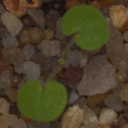

In [5]:
cv2_imshow(images[5])

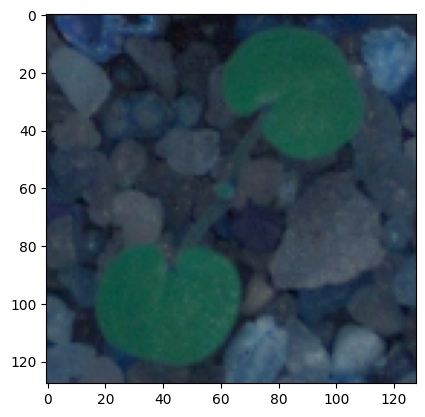

In [6]:
plt.imshow(images[5])

#### Converting the BGR images to RGB images.

In [7]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [8]:
def plot_images(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()

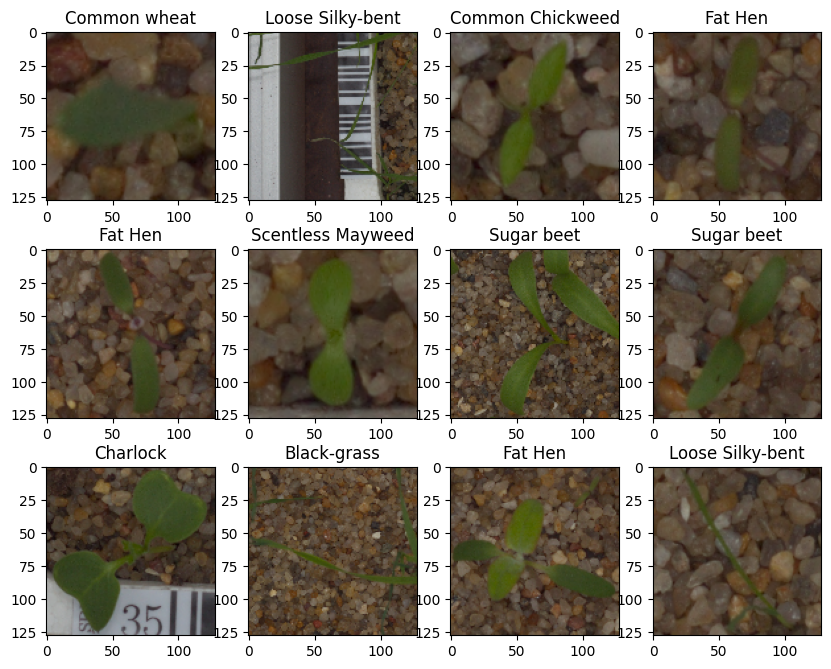

In [9]:
plot_images(images,labels)

### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [10]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

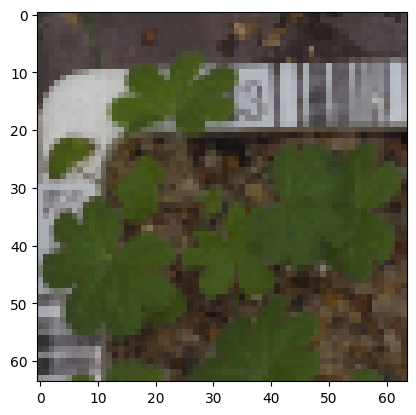

In [11]:
plt.imshow(images_decreased[3])

<b> Checking for data imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

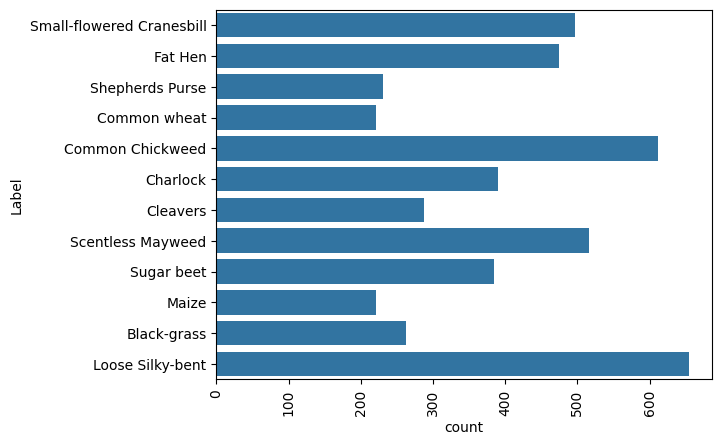

In [12]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is unbalanced.

## Visualizing images using Gaussian Blur

In [13]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

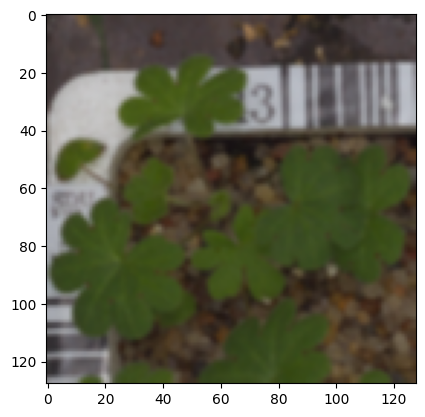

In [14]:
plt.imshow(images_gb[3])

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

### Data Preparation for modeling

- Before we proceed to build a model, we need to split the data into train, test, and validation to be able to evaluate the model that we build on the train data
- We will have to encode categorical features and scale the pixel values.
- We will build a model using the train data and then check its performance

#### Splitting the dataset

- We will use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [15]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [16]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


#### Encoding the target labels

In [17]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [18]:
print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)

(3847, 12)
(428, 12)
(475, 12)


#### Data Normalization (Scaling)
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [19]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [20]:
print(X_train_normalized.shape)
print(X_val_normalized.shape)
print(X_test_normalized.shape)

(3847, 64, 64, 3)
(428, 64, 64, 3)
(475, 64, 64, 3)


### Model Building - Convolutional Neural Network (CNN)


First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's **set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow** to be able to reproduce the same results every time we run the code.



#### Clearing the backend session and initializing the random seed values

In [21]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [22]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

We will build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [23]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

### <b> Fitting the model on the train data

In [24]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 13s - loss: 2.4533 - accuracy: 0.1258 - val_loss: 2.3831 - val_accuracy: 0.1379 - 13s/epoch - 111ms/step
Epoch 2/30
121/121 - 1s - loss: 2.2984 - accuracy: 0.1827 - val_loss: 2.1430 - val_accuracy: 0.2593 - 1s/epoch - 9ms/step
Epoch 3/30
121/121 - 1s - loss: 2.1007 - accuracy: 0.2508 - val_loss: 1.9168 - val_accuracy: 0.3411 - 1s/epoch - 9ms/step
Epoch 4/30
121/121 - 1s - loss: 1.9826 - accuracy: 0.2880 - val_loss: 1.8305 - val_accuracy: 0.3388 - 1s/epoch - 9ms/step
Epoch 5/30
121/121 - 1s - loss: 1.9458 - accuracy: 0.2797 - val_loss: 1.7619 - val_accuracy: 0.3575 - 1s/epoch - 12ms/step
Epoch 6/30
121/121 - 2s - loss: 1.9032 - accuracy: 0.2943 - val_loss: 1.7533 - val_accuracy: 0.3715 - 2s/epoch - 13ms/step
Epoch 7/30
121/121 - 1s - loss: 1.8850 - accuracy: 0.3039 - val_loss: 1.6837 - val_accuracy: 0.4042 - 1s/epoch - 12ms/step
Epoch 8/30
121/121 - 1s - loss: 1.8257 - accuracy: 0.3265 - val_loss: 1.6305 - val_accuracy: 0.4393 - 1s/epoch - 12ms/step
Epoch 9/30
121/1

### **Model Evaluation**

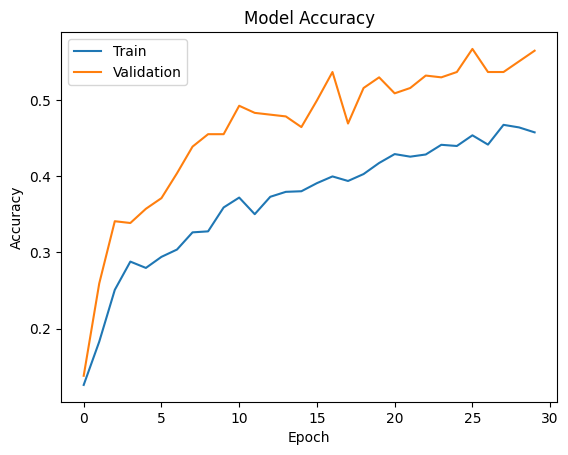

In [25]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was good but the validation accuracy was not good.**
*   The model seems to underfit on the data.


### **Evaluating the model on test data**

In [26]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2892 - accuracy: 0.5663 - 157ms/epoch - 10ms/step


### **Generating the predictions using test data**

In [27]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 2ms/step


In [28]:
y_pred

array([[3.27910993e-06, 2.18846399e-04, 7.76065718e-08, ...,
        1.05115876e-01, 5.29093668e-02, 1.33888470e-02],
       [2.22221696e-13, 3.03634610e-02, 2.89616524e-03, ...,
        1.78862158e-02, 8.67477417e-01, 6.00408018e-02],
       [2.80583690e-09, 4.88963490e-03, 3.86147003e-04, ...,
        1.77445021e-02, 8.02333057e-01, 9.83919874e-02],
       ...,
       [2.29774535e-01, 8.68507684e-08, 1.35331030e-03, ...,
        2.04334563e-10, 1.21425332e-08, 1.51389632e-02],
       [8.86975977e-06, 9.04677808e-02, 1.51405456e-02, ...,
        1.75404593e-01, 3.68834473e-02, 3.54312882e-02],
       [1.42261897e-05, 2.62534507e-02, 2.10834132e-03, ...,
        1.20635495e-01, 3.45500171e-01, 2.02706933e-01]], dtype=float32)

### **Plotting the Confusion Matrix**

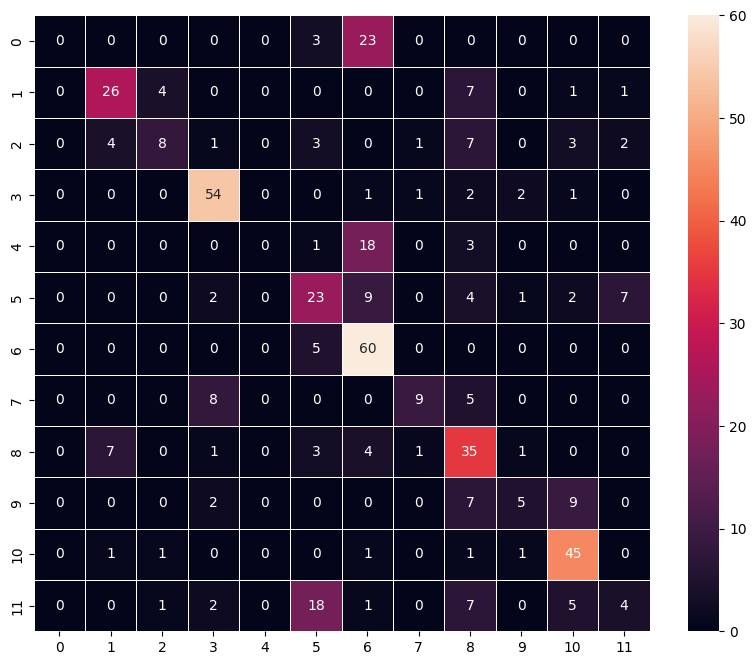

In [29]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that most of the classes are not predicted correctly.
- In comparison to the rest, we can see that classes 1 and 10 are well classified.
- We can also observe that classes 0,2,4,7,9 and 11 are mostly misclassified.

In [30]:
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.68      0.67      0.68        39
           2       0.57      0.28      0.37        29
           3       0.77      0.89      0.82        61
           4       0.00      0.00      0.00        22
           5       0.41      0.48      0.44        48
           6       0.51      0.92      0.66        65
           7       0.75      0.41      0.53        22
           8       0.45      0.67      0.54        52
           9       0.50      0.22      0.30        23
          10       0.68      0.90      0.78        50
          11       0.29      0.11      0.15        38

    accuracy                           0.57       475
   macro avg       0.47      0.46      0.44       475
weighted avg       0.50      0.57      0.51       475



In [31]:
del model
del history_1

In [32]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [33]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Model-2

As we can see, our initial model appears to underfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

# **Improving the Base Model using Data Augmentation and Regularization**

In [34]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

## **Data Augmentation**

In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is **Data Augmentation**. CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. <br> Taking this attribute into account, we can augment the images using the techniques listed below - <br>
**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>

In [35]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [36]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [37]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))
model1.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [38]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model1.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 8s 105ms/step - loss: 2.1346 - accuracy: 0.2487 - val_loss: 2.4460 - val_accuracy: 0.0701
Epoch 2/25
60/60 [==============================] - 4s 74ms/step - loss: 1.7130 - accuracy: 0.3944 - val_loss: 2.2865 - val_accuracy: 0.2734
Epoch 3/25
60/60 [==============================] - 6s 92ms/step - loss: 1.4944 - accuracy: 0.4660 - val_loss: 2.2592 - val_accuracy: 0.1495
Epoch 4/25
60/60 [==============================] - 5s 76ms/step - loss: 1.3836 - accuracy: 0.5139 - val_loss: 2.0914 - val_accuracy: 0.4813
Epoch 5/25
60/60 [==============================] - 7s 110ms/step - loss: 1.2985 - accuracy: 0.5411 - val_loss: 1.8038 - val_accuracy: 0.5888
Epoch 6/25
60/60 [==============================] - 4s 74ms/step - loss: 1.1859 - accuracy: 0.5749 - val_loss: 1.6163 - val_accuracy: 0.5491
Epoch 7/25
60/60 [==============================] - 6s 107ms/step - loss: 1.1357 - accuracy: 0.5998 - val_loss: 1.6079 - val_accuracy: 0.5678
Epoch 8/25

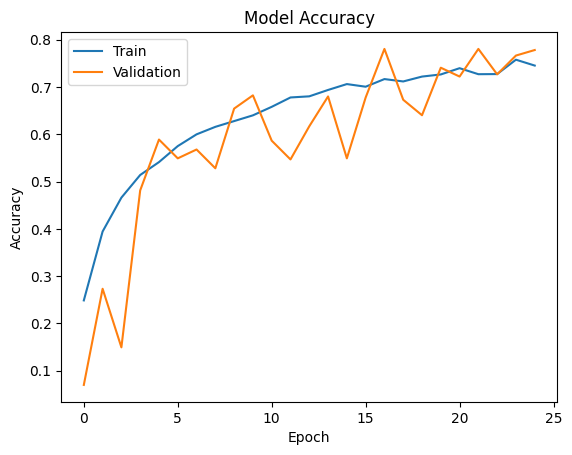

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.6791 - accuracy: 0.8000 - 67ms/epoch - 4ms/step


We can observe that our accuracy has improved compared to our previous model.

In [41]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)

15/15 [==============================] - 0s 3ms/step


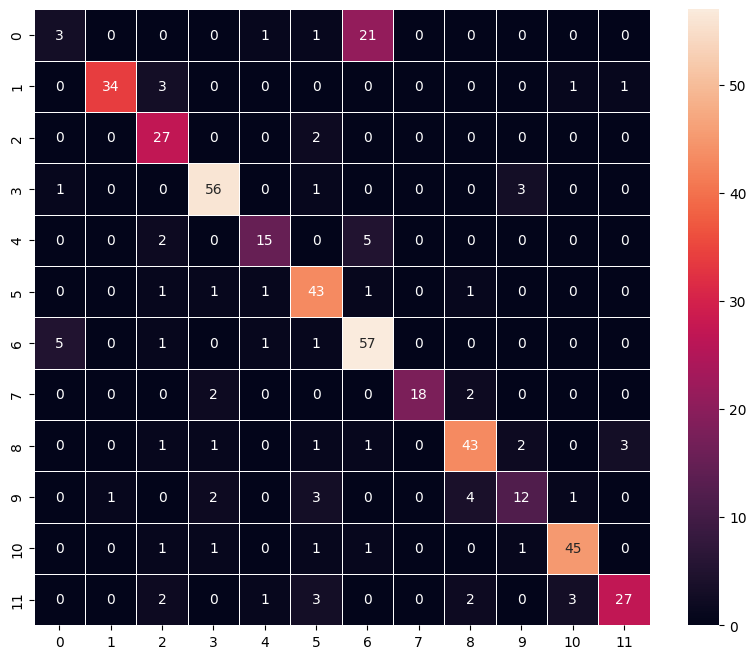

In [42]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observation:**
- The confusion matrix appears to be improving.
- We can observe that this model has outperformed our previous model.
- In comparison to the rest, we can see that classes 1,3, and 10 are well classified.
- We observe that most of the classes are predicted correctly.
- We can also observe that only classe 0 is mostly misclassified.

In [43]:
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg))

              precision    recall  f1-score   support

           0       0.33      0.12      0.17        26
           1       0.97      0.87      0.92        39
           2       0.71      0.93      0.81        29
           3       0.89      0.92      0.90        61
           4       0.79      0.68      0.73        22
           5       0.77      0.90      0.83        48
           6       0.66      0.88      0.75        65
           7       1.00      0.82      0.90        22
           8       0.83      0.83      0.83        52
           9       0.67      0.52      0.59        23
          10       0.90      0.90      0.90        50
          11       0.87      0.71      0.78        38

    accuracy                           0.80       475
   macro avg       0.78      0.76      0.76       475
weighted avg       0.79      0.80      0.79       475



# Transfer Learning using VGG16

- Let's try again, but this time, we will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [44]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [45]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [46]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [47]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [48]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 6630

In [49]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 12s 152ms/step - loss: 2.4218 - accuracy: 0.1554 - val_loss: 2.2954 - val_accuracy: 0.2150
Epoch 2/25
60/60 [==============================] - 5s 84ms/step - loss: 2.2183 - accuracy: 0.2591 - val_loss: 2.1337 - val_accuracy: 0.3061
Epoch 3/25
60/60 [==============================] - 6s 102ms/step - loss: 2.0405 - accuracy: 0.2947 - val_loss: 1.9811 - val_accuracy: 0.3178
Epoch 4/25
60/60 [==============================] - 6s 93ms/step - loss: 1.8971 - accuracy: 0.3434 - val_loss: 1.8744 - val_accuracy: 0.3738
Epoch 5/25
60/60 [==============================] - 5s 78ms/step - loss: 1.7955 - accuracy: 0.3791 - val_loss: 1.7965 - val_accuracy: 0.4112
Epoch 6/25
60/60 [==============================] - 7s 117ms/step - loss: 1.7268 - accuracy: 0.3981 - val_loss: 1.7512 - val_accuracy: 0.4019
Epoch 7/25
60/60 [==============================] - 5s 83ms/step - loss: 1.6664 - accuracy: 0.4185 - val_loss: 1.7000 - val_accuracy: 0.4042
Epoch 8/2

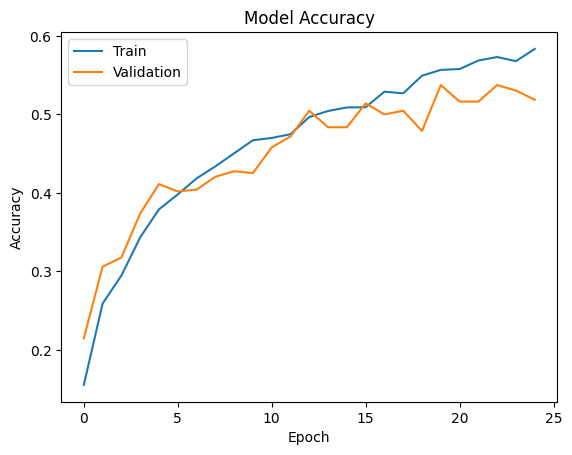

In [50]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.2731 - accuracy: 0.5726 - 1s/epoch - 78ms/step


In [52]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 0s 13ms/step


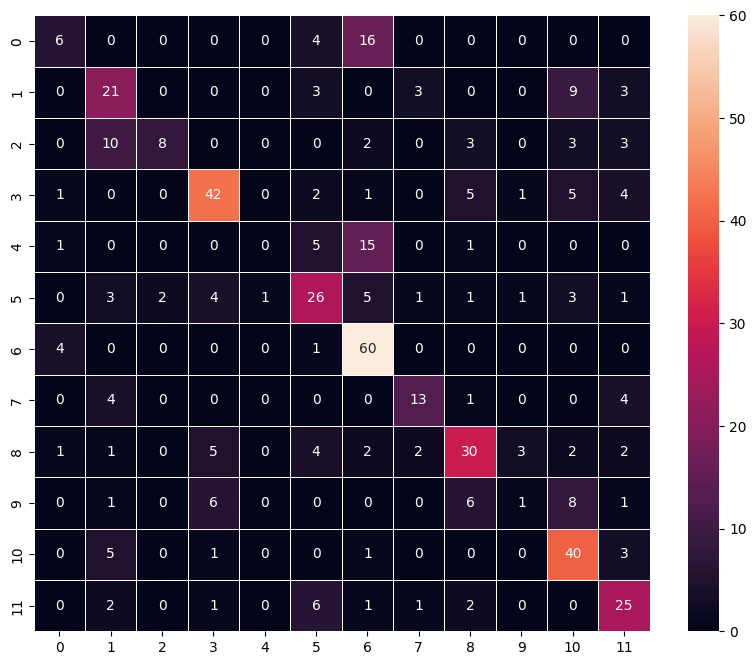

In [53]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model has not outperformed Model-2, since model-2 has an accuracy of 73% while VGG16 model has an accuracy of 58%.
- Thus we can say that Model-2 is our best model and we can use this model to predict and visualize some test images.

### **Plotting Classification Report**

In [54]:
from sklearn.metrics import classification_report
print(classification_report((y_test_arg), y_pred_arg))

              precision    recall  f1-score   support

           0       0.46      0.23      0.31        26
           1       0.45      0.54      0.49        39
           2       0.80      0.28      0.41        29
           3       0.71      0.69      0.70        61
           4       0.00      0.00      0.00        22
           5       0.51      0.54      0.53        48
           6       0.58      0.92      0.71        65
           7       0.65      0.59      0.62        22
           8       0.61      0.58      0.59        52
           9       0.17      0.04      0.07        23
          10       0.57      0.80      0.67        50
          11       0.54      0.66      0.60        38

    accuracy                           0.57       475
   macro avg       0.50      0.49      0.47       475
weighted avg       0.54      0.57      0.54       475



## **Visualizing the prediction:**

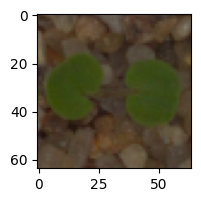

1/1 [==============================] - 0s 148ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


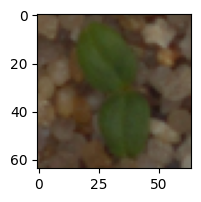

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Cleavers']
True Label Cleavers


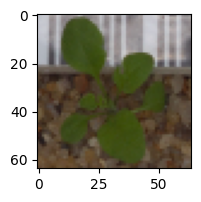

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [55]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model1.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model1.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model1.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Conclusion
- We can observe from the confusion matrix of all the models that our model-2 was the best model because it predicted the majority of the classes better than the other models.
- The test accuracy of the model-2 is 73%.
- Data Augmentation has also helped in improving the model.
- Simply employing data augmentation can produce a better outcome than any ordinary CNN.

## Scope of Improvement
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.
- Other data augmentation techniques can also be used to train the CNN model and these models can be used for classification.

# **Save the Model1**

In [56]:
model1.save('model.h5')

In [57]:
from google.colab import files

# For TensorFlow/Keras
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>